In [1]:
import pathlib
import json
from IPython.display import clear_output
import cv2
import numpy as np

In [6]:
# js_files = list(pathlib.Path(r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\official').iterdir())
js_files = list(pathlib.Path(r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\official').iterdir())
errors = {}
for i,js in enumerate(js_files):
    print(i)
    official_label = json.loads(js.read_text(encoding='utf8'))
    H = int(official_label['imageHeight'])
    W = int(official_label['imageWidth'])
    
    bboxes = []
    for shape_idx,shape in enumerate(official_label['shapes']):
        polygon = np.array(shape['points'])
        if polygon.shape != (4,2):
            errors.setdefault(official_label['imagePath'],[]).append(['非四邊形',shape_idx,shape])
            continue
        #因為標記座標可能超出圖片範圍，所以要修正
        polygon[:,0] = np.clip(polygon[:,0],0,W)
        polygon[:,1] = np.clip(polygon[:,1],0,H)
        if len(set((x,y) for x,y in polygon)) != 4:
            errors.setdefault(official_label['imagePath'],[]).append(['重合點',shape_idx,shape])
            continue
        #重新排序points
        P1 = polygon[polygon[:,1]==np.min(polygon[:,1],axis=0)] #找出y為最小值的點(可能不只一個)
        if P1.shape == (2,2): #如果有兩個則只取x最小的那個點
            P1 = P1[P1[:,0] == np.min(P1[:,0])]
        else:
            #如果取出來超過兩點表示三點共線，該四點不可能組合成四邊形，是有問題的資料
            if P1.shape != (1,2):
                errors.setdefault(official_label['imagePath'],[]).append(['多點共線',shape_idx,shape])
                continue
        #P1已經確定
        other_points = polygon[~(polygon == P1).all(axis=1)] #將P1從四點中移出
        vectors = other_points - P1 #計算P1到其他三點的向量
        cosine = vectors[:,0] / np.sqrt(np.sum(vectors**2,axis=1)) #求得向量與x單位向量之夾角cosine
        other_points = other_points[np.argsort(-cosine)] 
        #其餘三點依定義:夾角大小排列為P2,P3,P4，且夾角越大則cosine越小，依cosine排序則為P4,P3,P2，為了使結果為P2-4，cosine補-號
        polygon = np.concatenate([P1,other_points],axis=0) #將P1-4依順序合併，得到依順時針繞的四邊形
        #重新定義P1是距離bbox左上角最近的點，剩下依順時鐘繞
        P1_loc = np.argmin(((polygon - polygon.min(axis=0))**2).sum(axis=-1))
        polygon = np.roll(polygon,-P1_loc,axis=0)
        # P1P2應該是比較水平的向量
        vectors = polygon[[0,1]] - polygon[[-1,0]]
        cosine = vectors[:,0]/np.sqrt(np.sum(vectors**2,axis=1))
        polygon = np.roll(polygon,np.argmin(cosine),axis=0)
        
        #(left,top)為bbox左上角座標  w,h是寬高長度
        left,top,w,h = cv2.boundingRect(polygon)
        #避免左上角超出圖片範圍
        left =  np.clip(left,0,W)
        top = np.clip(top,0,H)
        #長寬不明原因會大於圖片長寬，用np.clip處理
        #另外還要注意左上座標加上長寬不能超過圖片大小
        w = np.clip(w,0,W-left)
        h = np.clip(h,0,H-top)
        
        #四邊形座標依照圖片尺寸正規化
        polygon = polygon/np.array([W,H])
        #矩形bbox的xywh依照圖片尺寸正規化
        left,w = left/W, w/W
        top,h = top/H, h/H
        
        right = left + w
        bottom = top + h
        
        bbox = {}
        bbox['text'] = shape['label']
        
        if shape['group_id'] == 255:
            bbox['type'] = 1
        else:
            bbox['type'] = shape['group_id'] + 2
            
        
        bbox['rectangle'] = {}
        bbox['rectangle']['center'] = [(left + right)/2, (top + bottom)/2]
        bbox['rectangle']['ltwh'] = [left,top,w,h]
        bbox['rectangle']['points'] = [[left,top],[right,top],[right,bottom],[left,bottom]]
        
        bbox['polygon'] = {}
        bbox['polygon']['center'] = polygon.mean(axis=0).tolist()
        bbox['polygon']['points'] = polygon.tolist()
        
        bboxes.append(bbox)
    
    if len(bboxes) == 0:
        errors.setdefault(official_label['imagePath'],[]).append(['無標籤',official_label['shapes']])
        continue
    
    my_label = {}
    my_label['ImageName'] = official_label['imagePath']
    my_label['ImageHeight'] = H
    my_label['ImageWidth'] = W
    my_label['bboxes'] = bboxes
    my_label['bboxes_count'] = len(bboxes)
    
    s = json.dumps(my_label)
    pathlib.Path(r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\custom').joinpath(js.name).write_text(s)
#     pathlib.Path(r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\custom').joinpath(js.name).write_text(s)
    clear_output(wait=True)
print('Finish')

Finish


In [3]:
len(errors)

36

In [4]:
errors

{'img_1022.jpg': [['多點共線',
   3,
   {'label': '###',
    'points': [[131, 0], [137, 0], [155, 0], [144, 18]],
    'group_id': 255,
    'shape_type': 'polygon',
    'flags': {}}]],
 'img_11470.jpg': [['重合點',
   11,
   {'label': '###',
    'points': [[0, 1276], [13, 1277], [0, 1337], [0, 1337]],
    'group_id': 255,
    'shape_type': 'polygon',
    'flags': {}}]],
 'img_11480.jpg': [['多點共線',
   9,
   {'label': '###',
    'points': [[0, 0], [175, 0], [174, 0], [0, 11]],
    'group_id': 255,
    'shape_type': 'polygon',
    'flags': {}}]],
 'img_13587.jpg': [['多點共線',
   3,
   {'label': '###',
    'points': [[1480, 0], [1483, 0], [1530, 0], [1529, 22]],
    'group_id': 255,
    'shape_type': 'polygon',
    'flags': {}}]],
 'img_1896.jpg': [['多點共線',
   17,
   {'label': '###',
    'points': [[865, 0], [871, 0], [897, 0], [893, 18]],
    'group_id': 255,
    'shape_type': 'polygon',
    'flags': {}}]],
 'img_2004.jpg': [['多點共線',
   1,
   {'label': '',
    'points': [[1018, 0], [1047, 0], [1093

In [7]:
import matplotlib.pyplot as plt

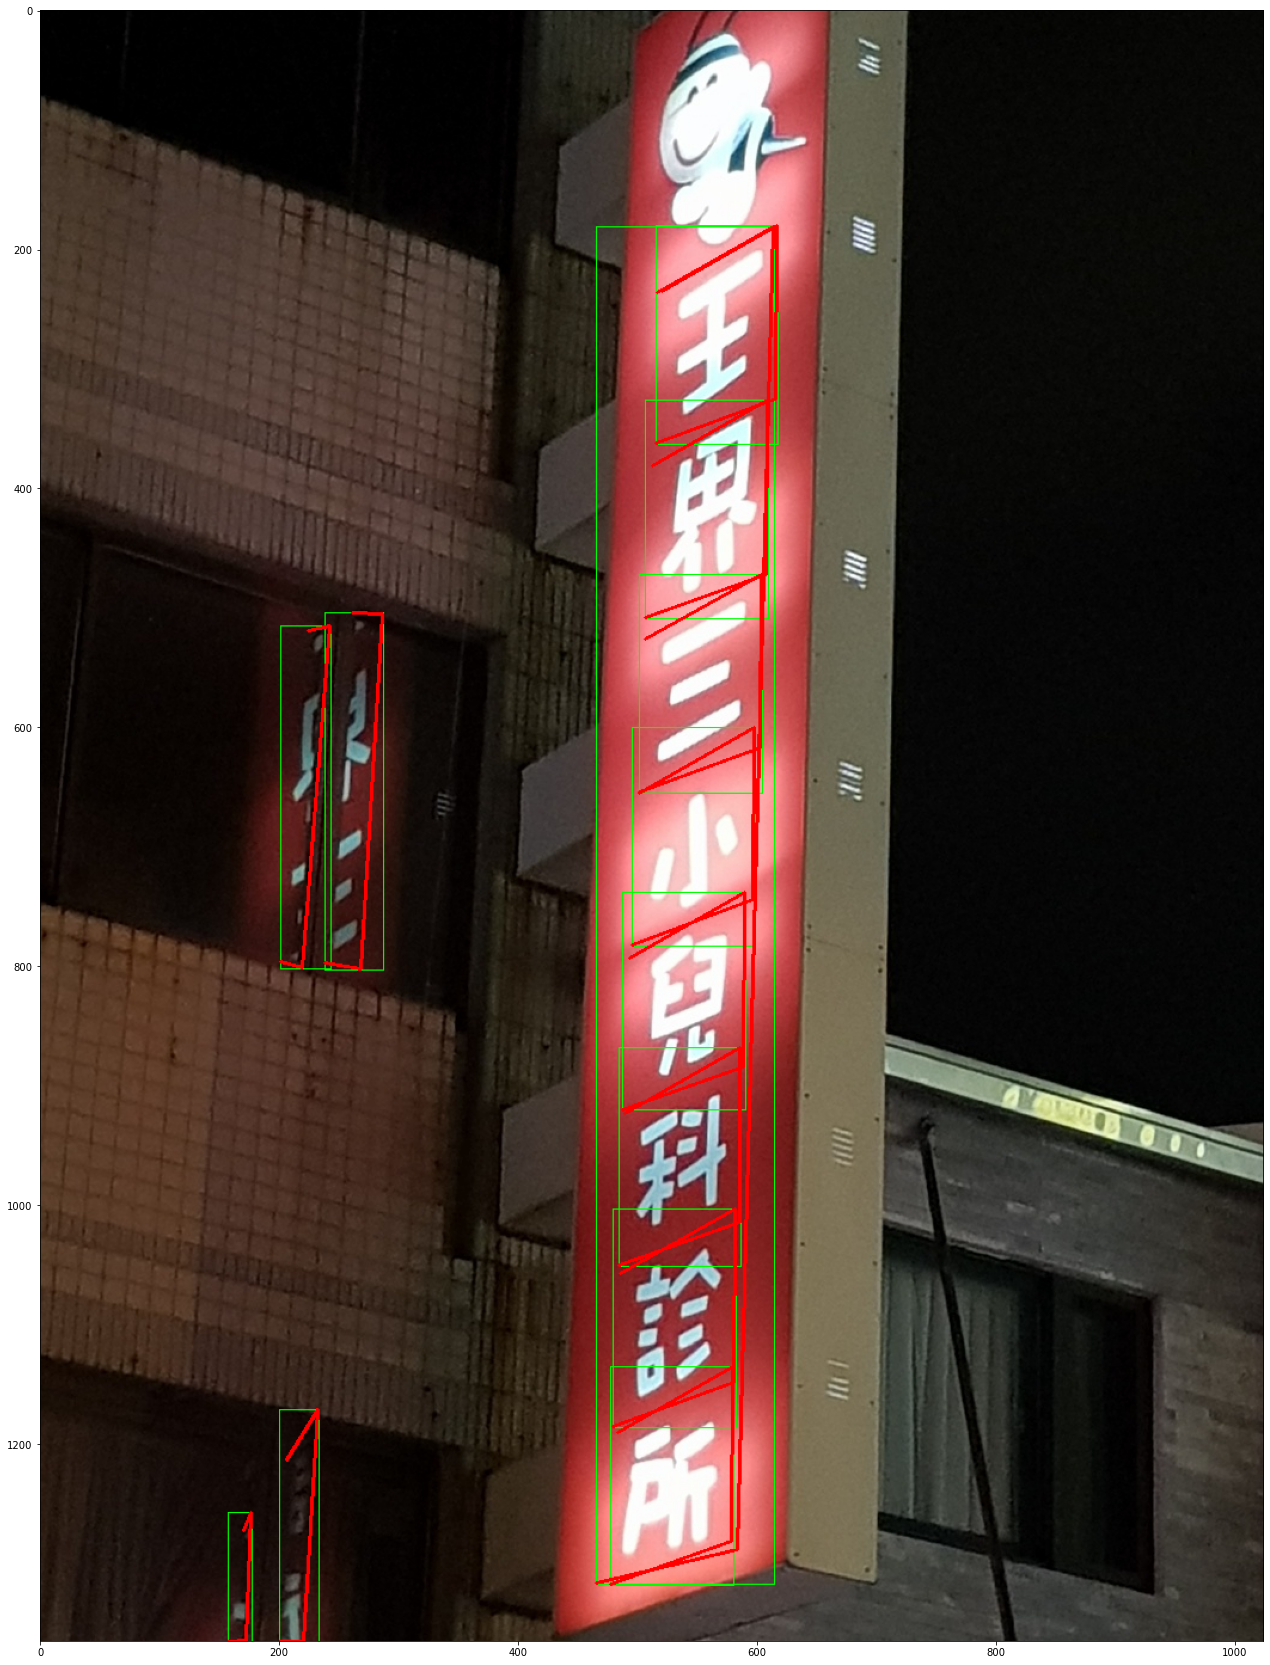

In [31]:
number = 419
name = f'img_{number}.json'
# x = json.loads(pathlib.Path(r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\custom').joinpath(name).read_text(encoding='utf8'))
# img = plt.imread(pathlib.Path(r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\image\official').joinpath(x['ImageName']))

x = json.loads(pathlib.Path(r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\custom').joinpath(name).read_text(encoding='utf8'))
img = plt.imread(pathlib.Path(r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\image\official').joinpath(x['ImageName']))

rects = np.array([b['rectangle']['points'] for b in x['bboxes']])
rects = (rects * np.array([x['ImageWidth'],x['ImageHeight']])).astype(int)

polygon = np.array([b['polygon']['points'] for b in x['bboxes']])
polygon = (polygon * np.array([x['ImageWidth'],x['ImageHeight']])).astype(int)

img = cv2.polylines(img,rects,True,(0,255,0))
img = cv2.polylines(img,polygon,False,(255,0,0),2)

plt.figure(figsize=(30,30))
plt.imshow(img)